In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [32]:
train = pd.read_csv("../../dataset/raw/train.csv")
train.drop(["Unnamed: 0"], axis=1, inplace=True)
train.dropna(inplace=True)
train.head()

,floors_before_eq (total),old_building,plinth_area (ft^2),height_before_eq (ft),land_surface_condition,type_of_foundation,type_of_roof,type_of_ground_floor,type_of_other_floor,position,...,type_of_reinforcement_concrete,residential_type,no_family_residing,public_place_type,industrial_use_type,govermental_use_type,flexible_superstructure,wall_binding,wall_material,damage_grade
21,Has 1 floor,22.0,300 ft^2,10.0,Moderate slope,Clay Sand Mixed mortar-Stone/Brick,Bamboo/Timber Light roof,mud,Not applicable,Not attached,...,0.0,Non-residential,None,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,5.0
27,Three floor,22.0,360 ft^2,18.0,Flat,Clay mortar-Stone/Brick,Wood Light Roof or Bamboo Heavy Roof,Clay,TImber/Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,4.0
43,Floor 2,8.0,380 ft^2,17.0,Flat,Clay mortar-Stone/Brick,Wood Light Roof or Bamboo Light Roof,Brick or Stone,Timber-Planck,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,5.0
46,two,22.0,250 ft^2,14.0,Flat,Clay mortar-Stone/Brick,Bamboo/Timber Light roof,Clay,TImber/Bamboo-Mud,Not attached,...,0.0,Non-residential,None,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,5.0
92,Floor two,7.0,312 ft^2,13.0,Flat,Clay Sand Mixed mortar-Stone/Brick,Bamboo or Timber Light roof,Clay,TImber/Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,available,5.0,2.0,2.0


In [33]:
ordinal_col = ["land_surface_condition", "technical_solution_proposed"]

binary_col = ["flexible_superstructure", "public_place_type",
              "govermental_use_type", "has_secondary_use"]
numerical_col = ["floors_before_eq (total)", "old_building",
                 "plinth_area (ft^2)", "height_before_eq (ft)"]
target_col = ["damage_grade"]
categorical_col_lt5 = [col for col in train.columns if col not in ordinal_col +
                       binary_col + numerical_col + target_col and train[col].nunique() <= 4]
cat_col = [col for col in train.columns if col not in ordinal_col +
           binary_col + numerical_col + target_col and train[col].nunique() >= 5 and col != "Unnamed: 0"]

In [42]:
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

ordinal_col = ["land_surface_condition", "technical_solution_proposed"]

binary_col = ["flexible_superstructure", "public_place_type",
              "govermental_use_type", "has_secondary_use"]
numerical_col = ["floors_before_eq (total)", "old_building",
                 "plinth_area (ft^2)", "height_before_eq (ft)"]
target_col = ["damage_grade"]
categorical_col_lt5 = [col for col in train.columns if col not in ordinal_col +
                       binary_col + numerical_col + target_col and train[col].nunique() <= 4]
cat_col = [col for col in train.columns if col not in ordinal_col +
           binary_col + numerical_col + target_col and train[col].nunique() >= 5 and col != "Unnamed: 0"]


def clean(df, mode="train", ):
    # try:
    #     df.drop(["no_family_residing"], axis=1, inplace=True)
    # except:
    #     pass
    
    angka = {
        "one": 1,
        "two": 2,
        "three": 3,
        "four": 4,
        "five": 5,
        "six": 6,
        "seven": 7,
        "eight": 8,
        "nine": 9,
        "1st": 1,
        "2nd": 2,
        "3rd": 3,
        "fifth": 5,
        "second": 2,
        "third": 3,
        "3.00": 3,
    }

    delete = {
        "story": "",
        "stories": "",
        "floor": "",
        "floors": "",
        "has": "",
        "there is": "",
        "just": "",
        "-": "",
        "fl": "",
        "/": "",
    }

    df["floors_before_eq (total)"] = df["floors_before_eq (total)"]\
        .str.lower()\
        .replace(delete, regex=True)\
        .str.strip()\
        .replace(angka, regex=True)

    df["floors_before_eq (total)"] = df["floors_before_eq (total)"].astype(
        "float")
    df["plinth_area (ft^2)"] = df["plinth_area (ft^2)"].str.lower()

    df["plinth_area (ft^2)"] = df["plinth_area (ft^2)"].apply(
        lambda x: x.replace(" ft^2", ""))
    df["plinth_area (ft^2)"] = df["plinth_area (ft^2)"].apply(
        lambda x: x.replace("more than ", ""))
    df["plinth_area (ft^2)"] = df["plinth_area (ft^2)"].astype(
        "float")

    type_of_foundation_dict = {
        # "Mud mortar-Stone/Brick": "Clay mortar-Stone/Brick",
        "Bamboo/TImber": "Bamboo or Timber",
        "Bamboo/Timber": "Bamboo or Timber",
        "RC": "Reinforced Concrete",
        "Others": "Other",
        "Cement-Stone or Cement-Brick": "Cement-Stone/Brick"
    }

    df["type_of_foundation"] = df["type_of_foundation"]\
        .replace(type_of_foundation_dict)\
        .str.strip()

    type_of_roof_dict = {
        "Bamboo/TImber-Heavy Roof": "Bamboo/Timber Heavy roof",
        "Bamboo/TImber-Light Roof": "Bamboo or Timber Light roof",
        "Bamboo/Timber Light roof": "Bamboo or Timber Light roof ",
        "reinforced cement concrete/rb/rbc": "rcc/rb/rbc",
        "Reinforced brick concrete/rcc/rbc": "rcc/rb/rbc",
        "Bamboo or Timber Heavy roof": "Bamboo/Timber Heavy roof",
        "Reinforced Brick Slab/rcc/rbc": "rcc/rb/rbc",
    }

    df["type_of_roof"] = df["type_of_roof"].replace(
        type_of_roof_dict).str.strip()

    type_of_ground_floor_dict = {
        "rc": "reinforced concrete",
        "brick/stone": "brick or stone",
        # "lumber": "wood",
        # "timber": "wood",
        # "mud": "clay"
    }

    df["type_of_ground_floor"] = df["type_of_ground_floor"].str.lower()\
        .replace(type_of_ground_floor_dict)\


    type_of_other_floor_dict = {
        # "lumber-plank": "wood-plank",
        # "timber-planck": "wood-plank",
        "timber/bamboo-mud": "wood-mud or bamboo mud",
        "reinforced cement concrete/rb/rbc": "rcc/rb/rbc",
        "wood or bamboo mud": "wood-mud or bamboo mud",
        "timber mud or bamboo-mud": "wood-mud or bamboo mud"
    }

    df["type_of_other_floor"] = df["type_of_other_floor"]\
        .str.lower()\
        .replace(type_of_other_floor_dict)

    # df['no_family_residing'] = df['no_family_residing'].replace(
    #     'None', '0.0').astype('float')

    df["residential_type"] = df["residential_type"].replace({
        "Other Residential Type": "Other"
    })
    df['govermental_use_type'] = df['govermental_use_type'].replace(
        ['Police Offices'], 'Govermental Buildings')
    
    
    df["public_place_type"] = df["public_place_type"]\
        .apply(lambda x: "Public" if x != "Non-public" else "Non-public")

    legal_ownership_status_dict = {
        "Private": "Private",
        "Private Use": "Private",
        "Prvt": "Private",
        "Privste": "Private",
        "Public Use": "Public",
        "Public Space": "Public",
        "Institutional Use": "Institutional",
        "Institutionals": "Institutional",
        "Unknown": "Other",
        "Unspecified": "Other",
    }

    df["legal_ownership_status"] = df["legal_ownership_status"].str.strip(
    ).replace(legal_ownership_status_dict)

    land_surface_condition_dict = {
        "Steep slope": 0,
        "Moderate slope": 1,
        "Flat": 2,
    }

    df["land_surface_condition"] = df["land_surface_condition"].replace(
        land_surface_condition_dict)

    technical_solution_proposed_dict = {
        "Reconstruction": 0,
        "Major repair": 1,
        "Minor repair": 2,
        "No need": 3,
    }

    df["technical_solution_proposed"] = df["technical_solution_proposed"].replace(
        technical_solution_proposed_dict)

    flexible_superstructure_dict = {
        "unavailable": 0,
        "available": 1,
    }

    df["flexible_superstructure"] = df["flexible_superstructure"].replace(
        flexible_superstructure_dict)

    public_place_type_dict = {
        "Public": 0,
        "Non-public": 1,
    }

    df["public_place_type"] = df["public_place_type"].replace(
        public_place_type_dict)

    governmental_use_type_dict = {
        "Govermental Buildings": 0,
        "Non-govermental": 1,
    }

    df["govermental_use_type"] = df["govermental_use_type"].replace(
        governmental_use_type_dict)

    return df

In [88]:
train_clean = train.copy()
train_clean = clean(train_clean)
train_clean.head()

,floors_before_eq (total),old_building,plinth_area (ft^2),height_before_eq (ft),land_surface_condition,type_of_foundation,type_of_roof,type_of_ground_floor,type_of_other_floor,position,...,type_of_reinforcement_concrete,residential_type,no_family_residing,public_place_type,industrial_use_type,govermental_use_type,flexible_superstructure,wall_binding,wall_material,damage_grade
21,1.0,22.0,300.0,10.0,1,Clay Sand Mixed mortar-Stone/Brick,Bamboo or Timber Light roof,mud,not applicable,Not attached,...,0.0,Non-residential,None,1,Non-industrial,1,0,5.0,2.0,5.0
27,3.0,22.0,360.0,18.0,2,Clay mortar-Stone/Brick,Wood Light Roof or Bamboo Heavy Roof,clay,wood-mud or bamboo mud,Not attached,...,0.0,Non-residential,1.0,1,Non-industrial,1,0,5.0,2.0,4.0
43,2.0,8.0,380.0,17.0,2,Clay mortar-Stone/Brick,Wood Light Roof or Bamboo Light Roof,brick or stone,timber-planck,Not attached,...,0.0,Non-residential,1.0,1,Non-industrial,1,0,5.0,2.0,5.0
46,2.0,22.0,250.0,14.0,2,Clay mortar-Stone/Brick,Bamboo or Timber Light roof,clay,wood-mud or bamboo mud,Not attached,...,0.0,Non-residential,None,1,Non-industrial,1,0,5.0,2.0,5.0
92,2.0,7.0,312.0,13.0,2,Clay Sand Mixed mortar-Stone/Brick,Bamboo or Timber Light roof,clay,wood-mud or bamboo mud,Not attached,...,0.0,Non-residential,1.0,1,Non-industrial,1,1,5.0,2.0,2.0


In [89]:
def ordinalkan(df, feat):
    list_feat = train_clean.groupby(feat)["damage_grade"].mean().sort_values(ascending=True).index
    dict_feat = {}
    for i in range(len(list_feat)):
        dict_feat[list_feat[i]] = i
    
    df[feat] = df[feat].replace(dict_feat)

def perpus_ordinal(cats):
    kamus_ordinal = {}
    for feat in cats:
        list_feat = train_clean.groupby(
            feat)["damage_grade"].mean().sort_values(ascending=True).index
        kamus_ordinal[feat] = {}
        for i in range(len(list_feat)):
            kamus_ordinal[feat][list_feat[i]] = i
    return kamus_ordinal

        

cats = cat_col + categorical_col_lt5

for col in cats:
    ordinalkan(train_clean, col)

kamus = perpus_ordinal(cats)
kamus

{'type_of_foundation': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6},
 'type_of_roof': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
 'type_of_ground_floor': {0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8},
 'type_of_other_floor': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6},
 'building_plan_configuration': {0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9},
 'legal_ownership_status': {0: 0, 1: 1, 2: 2, 3: 3},
 'residential_type': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4},
 'no_family_residing': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8},
 'industrial_use_type': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8},
 'wall_binding': {0.0: 0, 1.0: 1, 2.0: 2, 3.0: 3, 4.0: 4, 5.0: 5},
 'position': {0: 0, 1: 1, 2: 2, 3: 3},
 'type_of_reinforcement_concrete': {0.0: 0, 1.0: 1, 2.0: 2, 3.0: 3},
 'wall_material': {0.0: 0, 1.0: 1, 2.0: 2, 3.0: 3}}

In [90]:
train_clean.columns

Index(['floors_before_eq (total)', 'old_building', 'plinth_area (ft^2)',
       'height_before_eq (ft)', 'land_surface_condition', 'type_of_foundation',
       'type_of_roof', 'type_of_ground_floor', 'type_of_other_floor',
       'position', 'building_plan_configuration',
       'technical_solution_proposed', 'legal_ownership_status',
       'has_secondary_use', 'type_of_reinforcement_concrete',
       'residential_type', 'no_family_residing', 'public_place_type',
       'industrial_use_type', 'govermental_use_type',
       'flexible_superstructure', 'wall_binding', 'wall_material',
       'damage_grade'],
      dtype='object')

In [120]:
train_clean["building_wall_scoring"] = train_clean["wall_binding"] + train_clean["wall_material"] + train_clean["type_of_reinforcement_concrete"]
train_clean["building_floor_scoring"] = train_clean["type_of_foundation"] + \
    train_clean["land_surface_condition"] + \
    train_clean["type_of_ground_floor"] + train_clean["type_of_other_floor"]


In [91]:
d_train_clean = train_clean.drop(
    ["wall_binding", "wall_material", "type_of_reinforcement_concrete", "type_of_foundation", "land_surface_condition", "type_of_ground_floor", "type_of_other_floor"], axis=1)

In [127]:
y+=1

In [128]:
X = train_clean.drop(["damage_grade"], axis=1)
y = train_clean["damage_grade"]
y-=1

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [129]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

print(f1_score(y_test, y_pred, average='macro'))

0.6512998428183095


<Axes: xlabel='importance'>

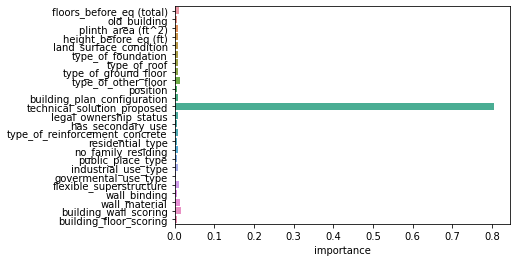

In [130]:
xgb_imp = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=["importance"])
xgb_imp.sort_values(by="importance", ascending=False)

sns.barplot(x=xgb_imp["importance"], y=xgb_imp.index)

In [131]:
from lightgbm import LGBMClassifier

l = LGBMClassifier()
l.fit(X_train, y_train)

y_pred = l.predict(X_test)

print(f1_score(y_test, y_pred, average='macro'))

0.6538046836020505


<Axes: xlabel='importance'>

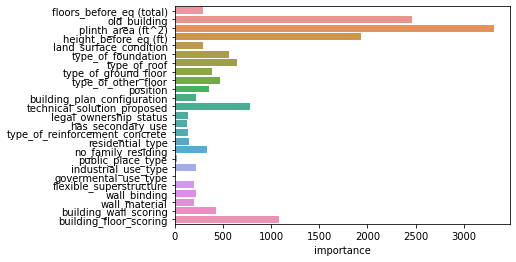

In [132]:
lgbm_imp = pd.DataFrame(l.feature_importances_, index=X_train.columns, columns=['importance'])
lgbm_imp.sort_values(by='importance', ascending=False)

sns.barplot(x='importance', y=lgbm_imp.index, data=lgbm_imp)